In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import gseapy as gp
import statsmodels.api as sm
from adjustText import adjust_text

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# scDRS tools
import scdrs

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Set file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
DF_HOM = pd.read_csv(DATA_PATH+'/gene_annotation/mouse_human_homologs.txt', sep='\t')
DIC_MAP_H2M = {x:y for x,y in zip(DF_HOM['HUMAN_GENE_SYM'], DF_HOM['MOUSE_GENE_SYM'])}
DIC_MAP_M2H = {x:y for x,y in zip(DF_HOM['MOUSE_GENE_SYM'], DF_HOM['HUMAN_GENE_SYM'])}
DF_GS = pd.read_csv(DATA_PATH+'/gs_file/magma_10kb_top1000_zscore.74_traits.rv1.gs', sep='\t', index_col=0)
DF_TRAIT_INFO = pd.read_csv(DATA_PATH+'/supp_table.rv1/trait_info.tsv', sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_contrast.rv1'

# Set data info
DS_LIST = ['tms_facs']
DIC_INFO = {}
DIC_INFO['tms_facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
DIC_INFO['tms_droplet'] = {'species': 'mmusculus', 'dname': 'TMS droplet'}
DIC_INFO['ts_facs'] = {'species': 'hsapiens', 'dname': 'TS FACS'}
DIC_INFO['canogamez'] = {'species': 'hsapiens', 'dname': 'Cano-Gamez & Soskic et al.'}
DIC_INFO['nathan'] = {'species': 'hsapiens', 'dname': 'Nathan et al.'}

# Set score file
DIC_SCORE_PATH = {
    'tms_facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_top1000_zscore',
    'tms_facs_pwexc': 
        DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_top1000_zscore_pairwise_exclusion',
    'tms_facs_uniform': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_top1000_uniform',
                 }

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['immune'] = [
    'PASS_IBD_deLange2017', 
    'PASS_CD_deLange2017',
    'PASS_UC_deLange2017', 
    'PASS_Rheumatoid_Arthritis', 
    'PASS_Multiple_sclerosis', 
    'UKB_460K.disease_AID_ALL', 
    'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
    'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED',
    'UKB_460K.disease_ASTHMA_DIAGNOSED', 
    'UKB_460K.disease_RESPIRATORY_ENT'
]
DIC_TRAIT_LIST['brain'] = [
    'PASS_BIP_Mullins2021', 
    'PASS_MDD_Howard2019', 
    'PASS_Schizophrenia_Pardinas2018', 
    'UKB_460K.mental_NEUROTICISM',
    'UKB_460K.cov_EDU_COLLEGE',
    'UKB_460K.body_BMIz',
    'UKB_460K.cov_SMOKING_STATUS'    
]
DIC_TRAIT_LIST['metabolic'] = [
    'UKB_460K.biochemistry_Triglycerides', 
    'UKB_460K.biochemistry_HDLcholesterol',
    'UKB_460K.biochemistry_LDLdirect',
    'UKB_460K.biochemistry_Cholesterol', 
    'UKB_460K.biochemistry_Testosterone_Male', 
    'UKB_460K.biochemistry_AlanineAminotransferase',
    'UKB_460K.biochemistry_AlkalinePhosphatase',
    'UKB_460K.biochemistry_SHBG', 
    'UKB_460K.biochemistry_TotalBilirubin'
]
DIC_TRAIT_LIST['tms_facs'] = list(DF_TRAIT_INFO['Trait_Identifier'])
DIC_TRAIT_LIST['tms_facs_uniform'] = list(DF_TRAIT_INFO['Trait_Identifier'])
DIC_TRAIT_LIST['tms_facs_pwexc'] = [
    x.replace('.score.gz','') for x in os.listdir(DIC_SCORE_PATH['tms_facs_pwexc']) if x.endswith('.score.gz')
]

for score in DIC_TRAIT_LIST:
    print('{:^20s} {:^20s}'.format(score, 'n_trait=%d'%len(DIC_TRAIT_LIST[score])))

       immune             n_trait=10     
       brain              n_trait=7      
     metabolic            n_trait=9      
      tms_facs            n_trait=74     
  tms_facs_uniform        n_trait=74     
   tms_facs_pwexc        n_trait=650     


### Load data 

In [3]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['tms_facs'] = scdrs.data_loader.load_tms_ct(DATA_PATH, data_name='facs')

dic_data_proc = {}
dic_data_proc['tms_facs.tcell'] = read_h5ad(
    '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/single_cell_data/tms_proc/tcell.facs.annot.h5ad')
dic_data_proc['tms_facs.hep'] = read_h5ad(
    '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/single_cell_data/tms_proc/hep.facs_annot.h5ad')

Trying to set attribute `.obs` of view, copying.


In [4]:
# Load score: 74 traits
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    print(score)
    for trait in DIC_TRAIT_LIST[score]:
        file_path = DIC_SCORE_PATH[score]+'/%s.score.gz'%trait
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path) 

tms_facs
tms_facs_pwexc
tms_facs_uniform


In [5]:
# Load control score: trait and cell_list
dic_load_ctrl_config = {}
for trait in DIC_TRAIT_LIST['immune']:
    dic_load_ctrl_config['tms_facs:%s'%trait] = sorted(
        set(dic_data_proc['tms_facs.tcell'].obs_names) & set(dic_score['tms_facs'].index)
    )

for config in dic_load_ctrl_config:
    print('%-10s %-50s n_cell_load=%d'%
          (config.split(':')[0], config.split(':')[1], len(dic_load_ctrl_config[config]))
         )
print('')
    
# Load control score 
print('Loading control score')
ctrl_list = ['ctrl_norm_score_%d'%x for x in range(1000)]
dic_ctrl_score = {}
for config in dic_load_ctrl_config:
    score,trait = config.split(':')
    cell_list = dic_load_ctrl_config[config]
    if score not in dic_ctrl_score:
        dic_ctrl_score[score] = {}
        
    file_path = DIC_SCORE_PATH[score]+'/%s.full_score.gz'%trait
    if os.path.exists(file_path):
        print('# Loading %s %s'%(score, trait))
#         temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
#         dic_ctrl_score[score][trait] = temp_df.loc[cell_list].copy()

        dic_ctrl_score[score][trait] = pd.read_csv(file_path, sep='\t', index_col=0)
    else:
        print('# missing: %s'%file_path)

tms_facs   PASS_IBD_deLange2017                               n_cell_load=3769
tms_facs   PASS_CD_deLange2017                                n_cell_load=3769
tms_facs   PASS_UC_deLange2017                                n_cell_load=3769
tms_facs   PASS_Rheumatoid_Arthritis                          n_cell_load=3769
tms_facs   PASS_Multiple_sclerosis                            n_cell_load=3769
tms_facs   UKB_460K.disease_AID_ALL                           n_cell_load=3769
tms_facs   UKB_460K.disease_HYPOTHYROIDISM_SELF_REP           n_cell_load=3769
tms_facs   UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED          n_cell_load=3769
tms_facs   UKB_460K.disease_ASTHMA_DIAGNOSED                  n_cell_load=3769
tms_facs   UKB_460K.disease_RESPIRATORY_ENT                   n_cell_load=3769

Loading control score
# Loading tms_facs PASS_IBD_deLange2017
# Loading tms_facs PASS_CD_deLange2017
# Loading tms_facs PASS_UC_deLange2017
# Loading tms_facs PASS_Rheumatoid_Arthritis
# Loading tms_facs PASS_

### Similarity across 74 traits:
1. Statistics: 
    - Gene set overlap 
    - Score correlation
2. Heatmap of traits from the same domain 

In [6]:
# Statistics: df_overlap & df_corr & df_corr_pwexc
ds,score,score_ref,score_pwexc = 'tms_facs','tms_facs','tms_facs_uniform','tms_facs_pwexc'
trait_list = list(DF_GS.index)
trait_list_main = DIC_TRAIT_LIST['immune'] + DIC_TRAIT_LIST['brain'] + DIC_TRAIT_LIST['metabolic']
cate_list = list(DF_TRAIT_INFO.loc[trait_list, 'Category'].unique())

df_overlap = pd.DataFrame(index=trait_list, columns=trait_list, dtype=int)
for i in range(len(trait_list)):
    for j in range(i, len(trait_list)):
        trait_i = trait_list[i]
        trait_j = trait_list[j]
        gene_list_i = [x.split(':')[0] for x in DF_GS.loc[trait_i, 'GENESET'].split(',')]
        gene_list_j = [x.split(':')[0] for x in DF_GS.loc[trait_j, 'GENESET'].split(',')]
        df_overlap.loc[trait_i, trait_j] = len(set(gene_list_i) & set(gene_list_j))
        df_overlap.loc[trait_j, trait_i] = len(set(gene_list_i) & set(gene_list_j))
df_overlap = df_overlap.astype(int)

df_corr = dic_score[score][['%s.norm_score'%x for x in trait_list]].corr()
df_corr.columns = [x.replace('.norm_score','') for x in df_corr.columns]
df_corr.index = [x.replace('.norm_score','') for x in df_corr.index]

df_corr_ref = dic_score[score_ref][['%s.norm_score'%x for x in trait_list]].corr()
df_corr_ref.columns = [x.replace('.norm_score','') for x in df_corr_ref.columns]
df_corr_ref.index = [x.replace('.norm_score','') for x in df_corr_ref.index]

df_corr_pwexc = pd.DataFrame(index=trait_list_main, columns=trait_list_main, dtype=float)
for i in range(len(trait_list_main)):
    for j in range(i+1,len(trait_list_main)):
        trait1,trait2 = trait_list_main[i],trait_list_main[j]
        score_pwexc1 = '%s_exc_%s.norm_score'%(trait1,trait2)
        score_pwexc2 = '%s_exc_%s.norm_score'%(trait2,trait1)
        if (score_pwexc1 not in dic_score[score_pwexc]) or (score_pwexc2 not in dic_score[score_pwexc]):
            continue
        corr_ = np.corrcoef(dic_score[score_pwexc][score_pwexc1], dic_score[score_pwexc][score_pwexc2])[0,1]
        df_corr_pwexc.loc[trait1, trait2] = corr_
        df_corr_pwexc.loc[trait2, trait1] = corr_
        
# Genetic correlation
DESCRIPTION_FILE = '/n/holystore01/LABS/price_lab/Lab/ldsc/sumstats_formatted_2021/Description_070121.xlsx'
DF_GENET_CORR = pd.read_excel(DESCRIPTION_FILE, sheet_name=2, index_col=0)

In [51]:
# Category-level summary
def pairwise_mean_jn(df_data):
    n_sample = df_data.shape[0]
    v_jn = np.zeros(n_sample)
    for i_col,col in enumerate(df_data):
        temp_df = df_data.loc[df_data.index!=col, df_data.columns!=col]
        v_val = temp_df.values[np.tril_indices(temp_df.shape[0], k=-1)]
        v_jn[i_col] = np.nanmean(v_val)
    return v_jn.mean(),v_jn.std() * np.sqrt((n_sample-1)/n_sample)

# Create a masked version 
df_overlap_mask = df_overlap.copy()
df_corr_mask = df_corr.copy()
df_corr_pwexc_mask = df_corr_pwexc.copy()
for cate in cate_list:
    trait_list_cate = [x for x in trait_list if DF_TRAIT_INFO.loc[x, 'Category']==cate]
    df_overlap_mask.loc[trait_list_cate, trait_list_cate] = np.nan
    df_corr_mask.loc[trait_list_cate, trait_list_cate] = np.nan
    temp_list = list(set(trait_list_cate) & set(df_corr_pwexc_mask.index))
    df_corr_pwexc_mask.loc[temp_list, temp_list] = np.nan

# Results across 26 main traits: overlap, correlation, and correlation excluding overlapping genes 
col_list = [
    '$N_{\text{trait}}$', 'Gene set overlap (SE)', 'Score corr (SE)', 'Score corr excl overlapping genes (SE)'
]
df_stats = pd.DataFrame(index = ['immune', 'brain', 'metabolic', 'inter-domain'], columns=col_list)
for cate in df_stats.index:
    if cate=='inter-domain':
        df_overlap_cate = df_overlap_mask.loc[trait_list_main, trait_list_main]
        df_corr_cate = df_corr_mask.loc[trait_list_main, trait_list_main]
        df_corr_pwexc_cate = df_corr_pwexc_mask.loc[trait_list_main, trait_list_main]
    else:
        trait_list_cate = DIC_TRAIT_LIST[cate]
        df_overlap_cate = df_overlap.loc[trait_list_cate, trait_list_cate]
        df_corr_cate = df_corr.loc[trait_list_cate, trait_list_cate]
        df_corr_pwexc_cate = df_corr_pwexc.loc[trait_list_cate, trait_list_cate]
        
    overlap_mean,overlap_se = pairwise_mean_jn(df_overlap_cate)
    corr_mean,corr_se = pairwise_mean_jn(df_corr_cate)    
    corr_pwexc_mean,corr_pwexc_se = pairwise_mean_jn(df_corr_pwexc_cate)    
    df_stats.loc[cate] = [df_corr_cate.shape[0],  '%0.1f (%0.1f)'%(overlap_mean,overlap_se),
                          '%0.3f (%0.3f)'%(corr_mean,corr_se), '%0.3f (%0.3f)'%(corr_pwexc_mean,corr_pwexc_se)]
df_stats.index = [x.capitalize() for x in df_stats.index]
print(df_stats.to_latex(index=True, escape=False, float_format="{:0.3f}".format, column_format='|c|cccc|'))  
    
# Results across 74 traits 
df_stats = pd.DataFrame(index = cate_list+['inter-domain'], columns=col_list)
for cate in df_stats.index:
    if cate=='inter-domain':
        df_overlap_cate = df_overlap_mask
        df_corr_cate = df_corr_mask
    else:
        trait_list_cate = [x for x in trait_list if DF_TRAIT_INFO.loc[x, 'Category']==cate]
        df_overlap_cate = df_overlap.loc[trait_list_cate, trait_list_cate]
        df_corr_cate = df_corr.loc[trait_list_cate, trait_list_cate]
    
    overlap_mean,overlap_se = pairwise_mean_jn(df_overlap_cate)
    corr_mean,corr_se = pairwise_mean_jn(df_corr_cate)    
    df_stats.loc[cate] = [df_corr_cate.shape[0], '%0.1f (%0.1f)'%(overlap_mean,overlap_se),
                          '%0.3f (%0.3f)'%(corr_mean,corr_se), '-']   
df_stats.index = [x.capitalize() for x in df_stats.index]
print(df_stats.to_latex(index=True, escape=False, float_format="{:0.3f}".format, column_format='|c|cccc|')) 

\begin{tabular}{|c|cccc|}
\toprule
{} & $N_{\text{trait}}$ & Gene set overlap (SE) & Score corr (SE) & Score corr excl overlapping genes (SE) \\
\midrule
Immune       &                 10 &          230.7 (10.0) &   0.507 (0.007) &                          0.162 (0.009) \\
Brain        &                  7 &           199.3 (4.4) &   0.440 (0.012) &                          0.169 (0.012) \\
Metabolic    &                  9 &           275.4 (9.6) &   0.355 (0.011) &                          0.016 (0.004) \\
Inter-domain &                 26 &           110.9 (1.1) &   0.018 (0.003) &                         -0.095 (0.003) \\
\bottomrule
\end{tabular}

\begin{tabular}{|c|cccc|}
\toprule
{} & $N_{\text{trait}}$ & Gene set overlap (SE) & Score corr (SE) & Score corr excl overlapping genes (SE) \\
\midrule
Brain        &                 21 &           154.5 (3.8) &   0.328 (0.009) &                                      - \\
Heart        &                  6 &          295.8 (56.5) &   0.4

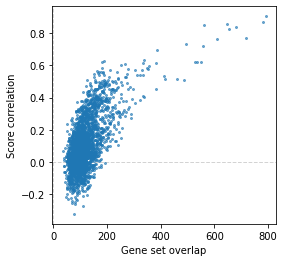

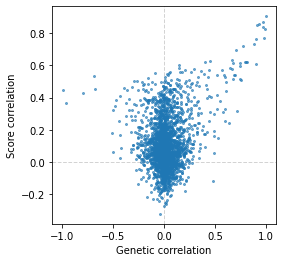

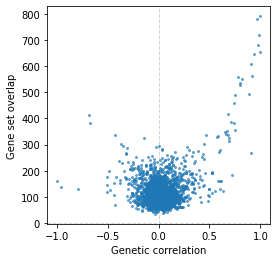

In [8]:
# Concordance between gene set overlap and score correlation
v_overlap = df_overlap.values[np.tril_indices(df_corr.shape[0], k=-1)]
v_corr = df_corr.values[np.tril_indices(df_corr.shape[0], k=-1)]
plt.figure(figsize=[4,4])
plt.scatter(v_overlap, v_corr, s=4, alpha=0.6)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
plt.plot([xmin,xmax],[0,0], '--', linewidth=1, color='lightgrey', zorder=0)
plt.plot([0,0],[ymin,ymax], '--', linewidth=1, color='lightgrey', zorder=0)
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.xlabel('Gene set overlap')
plt.ylabel('Score correlation')
plt.savefig(FIG_PATH+'/corr_vs_overlap.svg')
plt.savefig(FIG_PATH+'/corr_vs_overlap.png')
plt.show()

# Concordance between genetic correlation and score correlation
temp_list = sorted(set(df_corr) & set(DF_GENET_CORR))
v_genet_corr = DF_GENET_CORR.loc[temp_list, temp_list].values[np.tril_indices(len(temp_list), k=-1)]
v_corr = df_corr.loc[temp_list, temp_list].values[np.tril_indices(len(temp_list), k=-1)]
plt.figure(figsize=[4,4])
plt.scatter(v_genet_corr, v_corr, s=4, alpha=0.6)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
plt.plot([xmin,xmax],[0,0], '--', linewidth=1, color='lightgrey', zorder=0)
plt.plot([0,0],[ymin,ymax], '--', linewidth=1, color='lightgrey', zorder=0)
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.xlabel('Genetic correlation')
plt.ylabel('Score correlation')
plt.savefig(FIG_PATH+'/corr_vs_genetcorr.svg')
plt.savefig(FIG_PATH+'/corr_vs_genetcorr.png')
plt.show()

# Concordance between gene set overlap and genetic correlation
temp_list = sorted(set(df_overlap) & set(DF_GENET_CORR))
v_genet_corr = DF_GENET_CORR.loc[temp_list, temp_list].values[np.tril_indices(len(temp_list), k=-1)]
v_overlap = df_overlap.loc[temp_list, temp_list].values[np.tril_indices(len(temp_list), k=-1)]
plt.figure(figsize=[4,4])
plt.scatter(v_genet_corr, v_overlap, s=4, alpha=0.6)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
plt.plot([xmin,xmax],[0,0], '--', linewidth=1, color='lightgrey', zorder=0)
plt.plot([0,0],[ymin,ymax], '--', linewidth=1, color='lightgrey', zorder=0)
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.xlabel('Genetic correlation')
plt.ylabel('Gene set overlap')
plt.savefig(FIG_PATH+'/overlapp_vs_genetcorr.svg')
plt.savefig(FIG_PATH+'/overlapp_vs_genetcorr.png')
plt.show()

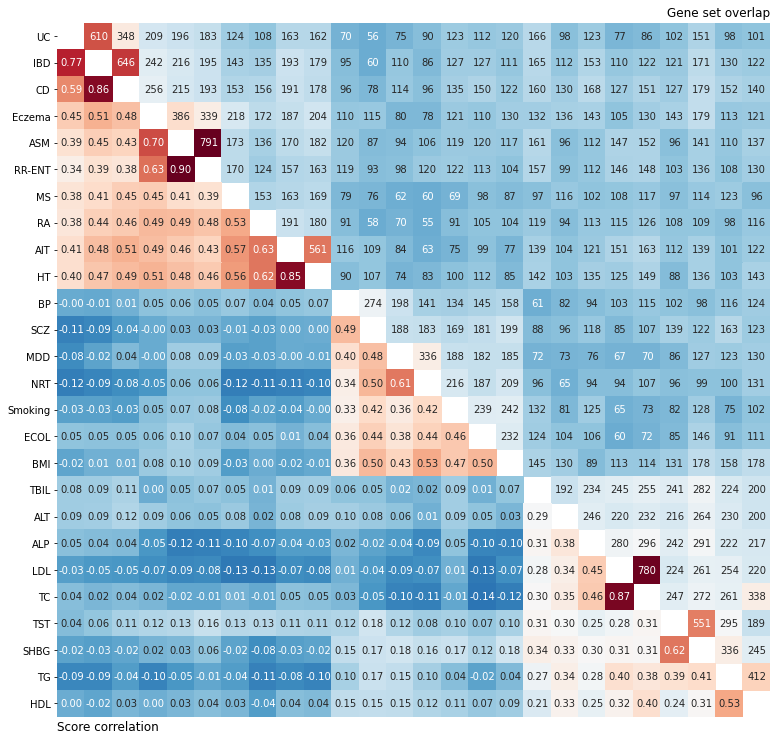

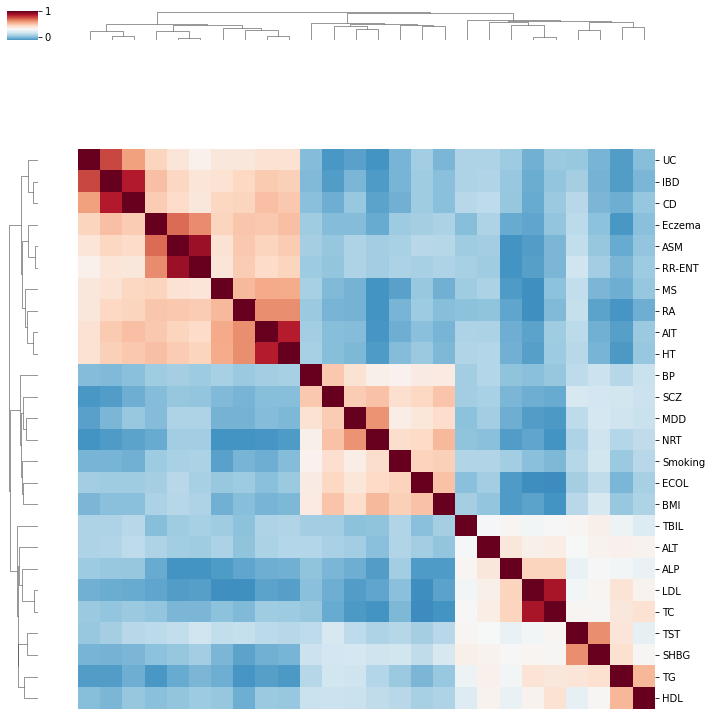

In [49]:
# Heatmap: overlap + correlation
def reorder_col(df_sim):
    mat_condensed_dist = sp.spatial.distance.squareform(1-df_sim)
    mat_linkage = sp.cluster.hierarchy.linkage(mat_condensed_dist, method='average')
    reordered_col_list = list(df_sim.columns[sp.cluster.hierarchy.leaves_list(mat_linkage)])
    return reordered_col_list,mat_linkage

cate = 'main'
trait_list_cate = trait_list_main

df_overlap_cate = df_overlap.loc[trait_list_cate, trait_list_cate]
df_corr_cate = df_corr.loc[trait_list_cate, trait_list_cate]
trait_list_reorder,mat_linkage = reorder_col(df_corr_cate)

df_plot_upper = df_overlap_cate.loc[trait_list_reorder, trait_list_reorder].copy()
df_plot_upper.index = [DF_TRAIT_INFO.loc[x, 'Code'] for x in df_plot_upper.index]
mat_mask_upper = np.tril(np.ones_like(df_plot_upper, dtype=np.bool), k=0)

df_plot_lower = df_corr_cate.loc[trait_list_reorder, trait_list_reorder].copy()
df_plot_lower.index = [DF_TRAIT_INFO.loc[x, 'Code'] for x in df_plot_lower.index]
mat_mask_lower = np.triu(np.ones_like(df_plot_lower, dtype=np.bool), k=0)

plt.figure(figsize=[0.5+len(trait_list_cate)*0.4, len(trait_list_cate)*0.4])
sns.heatmap(df_plot_upper, annot=df_plot_upper, fmt='d', mask=mat_mask_upper,
            xticklabels=False, yticklabels=False, cmap = 'RdBu_r', center=300, cbar=False)
sns.heatmap(df_plot_lower, annot=df_plot_lower, fmt='.2f', mask=mat_mask_lower,
            xticklabels=False, yticklabels=True, cmap = 'RdBu_r', center=0.3, cbar=False)
plt.yticks(rotation=0)     
plt.xlabel('Score correlation', loc='left', fontsize=12)
plt.title('Gene set overlap', loc='right', fontsize=12)
if cate != 'main':
    plt.title(cate.capitalize(), loc='left', fontsize=12)
plt.tight_layout()
plt.savefig(FIG_PATH+'/score_corr_main.svg')
plt.show()

# Clustermap to get dendrogram 
# plt.figure(figsize=[0.5+len(trait_list_cate)*0.4, len(trait_list_cate)*0.4])
df_clustermap = df_corr_cate.copy()
df_clustermap.index = [DF_TRAIT_INFO.loc[x, 'Code'] for x in df_clustermap.index]
sns.clustermap(df_clustermap, row_cluster=True, col_cluster=True, 
               row_linkage=mat_linkage, col_linkage=mat_linkage,
               xticklabels=False, yticklabels=True, 
               dendrogram_ratio=0.05, cmap = 'RdBu_r', center=0.3, cbar=True)
# plt.yticks(rotation=0)     
plt.tight_layout()
plt.savefig(FIG_PATH+'/score_corr_main.clustermap.svg')
plt.show()

In [10]:
# Comparison between zscore and uniform scDRS scores 
print('zscore vs. uniform')
v_val = df_corr.values[np.tril_indices(df_corr.shape[0], k=-1)]
v_val_ref = df_corr_ref.values[np.tril_indices(df_corr_ref.shape[0], k=-1)]
print('Corr. of df_corr', np.corrcoef(v_val, v_val_ref)[0,1])

# Score correlation and power improvement
v_corr = np.zeros(len(trait_list))
v_sig_ratio = np.zeros(len(trait_list))
for i_trait,trait in enumerate(trait_list):
    v_corr[i_trait] = np.corrcoef(
        dic_score[score]['%s.norm_score'%trait], dic_score[score_ref]['%s.norm_score'%trait]
    )[0,1]
    v_sig_ratio[i_trait] = ((dic_score[score]['%s.fdr'%trait]<0.1).sum()+1) / \
        ((dic_score[score_ref]['%s.fdr'%trait]<0.1).sum()+1)
print('Median score corrlation', np.median(v_corr))
print('Median sig ratio', np.median(v_sig_ratio))

zscore vs. uniform
Corr. of df_corr 0.9913488207826119
Median score corrlation 0.9819755195543912
Median sig ratio 1.0733284000949417


In [50]:

FIG_PATH

'/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_contrast.rv1'